In [16]:
# Required Libraries
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets,models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn,optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm #Progress bar
from torchvision.utils import draw_bounding_boxes

In [17]:
# Datset format is COCO(Common Objects in Context) so pycocotools is the required framework for using it
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Defining transforms that is RGB (each ranging from 0 to 255) values to Tensors(2D-array)
from albumentations.pytorch import ToTensorV2

In [19]:
from albumentations.augmentations.transforms import RandomBrightnessContrast
def get_transforms(train=False):
  if train:
     transform = A.Compose([
         A.Resize(600,600), # Input image size
         A.HorizontalFlip(p=0.3),
         A.VerticalFlip(p=0.3),
         A.RandomBrightnessContrast(p=0.1),
         A.ColorJitter(p=0.1),
         ToTensorV2() 
     ], bbox_params = A.BboxParams(format = 'coco'))
  else:
    transform = A.Compose([
         A.Resize(600,600), # Input image size
         ToTensorV2() 
     ], bbox_params = A.BboxParams(format = 'coco'))
  return transform

In [20]:
class VehicleDetection(datasets.VisionDataset):
  def __init__(self, root, split='train', transform = None, target_transform=None, transforms=None):
    # 3 transform parameters are required for datasets.VisionDatset
    super().__init__(root, transforms, transform, target_transform)
    self.split = split #train, valid, test
    self.coco = COCO(os.path.join(root,split, '_annotations.coco.json')) #annotations stored here
    self.ids = list(sorted(self.coco.imgs.keys()))
    self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
  
  def _load_image(self, id:int):
    path = self.coco.loadImgs(id)[0]['file_name']
    image = cv2.imread(os.path.join(self.root, self.split, path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

  def _load_target(self, id):
     return self.coco.loadAnns(self.coco.getAnnIds(id))
  
  def __getitem__(self, index):
    id = self.ids[index]
    image = self._load_image(id)
    target = self._load_target(id)
    target = copy.deepcopy(self._load_target(id))

    boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
    if self.transforms is not None:
      transformed = self.transforms(image=image, bboxes = boxes)

    image = transformed['image']
    boxes = transformed['bboxes']

    new_boxes = []
    for box in boxes:
      xmin = box[0]
      xmax = xmin + box[2]
      ymin = box[1]
      ymax = ymin + box[3]
      new_boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.tensor(new_boxes, dtype=torch.float32)

    targ = {} #Our transformed target
    targ['boxes'] = boxes
    targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
    targ['image_id'] = torch.tensor([t['image_id'] for t in target])
    targ['area'] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0]) # different area
    targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
    return image.div(255), targ # Scale images
  
  def __len__(self):
    return len(self.ids)


In [21]:
dataset_path = '/content/drive/MyDrive/Indian-Vehicle detection-v1'

In [22]:
# load classes
coco = COCO(os.path.join(dataset_path, 'train', '_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())
categories
n_classes

loading annotations into memory...
Done (t=13.45s)
creating index...
index created!


8

In [23]:
classes = [i[1]['name'] for i in categories.items()]
classes
num_classes = len(classes)

In [24]:
train_dataset = VehicleDetection(root = dataset_path, transforms = get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


<class 'tuple'>


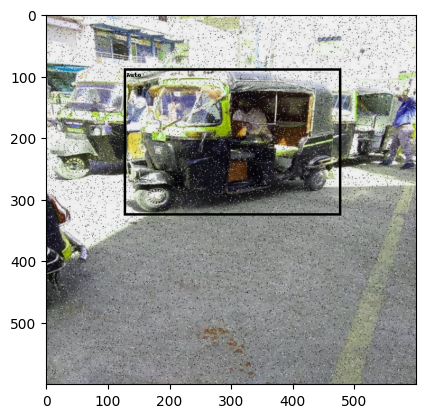

In [27]:
# Lets view a sample
sample = train_dataset[30]
print(type(sample))
img_int = torch.tensor(sample[0] * 255, dtype = torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1,2,0))

In [28]:
len(train_dataset)

1090

In [29]:
# Loading faster rcnn model
def create_model(n_classes):
  model = models.detection.fasterrcnn_resnet50_fpn_v2(pretrained = True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features ## changing the head
  model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features,n_classes)
  return model

In [30]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [31]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [32]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
model = create_model(n_classes)
output = model(images,targets)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 181MB/s]


In [33]:
device = torch.device('cuda') # Using GPU to Train

In [34]:
model = create_model(n_classes)
model = model.to(device)

In [35]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True,weight_decay=1e-4)

In [36]:
def train_one_epoch(model, optimizer, loader, device, epoch):
  model.to(device)
  model.train()

  all_losses = []
  all_losses_dict = []
  
  for images, targets in tqdm(loader):
    images = list(image.to(device) for image in images)
    targets = [{k: torch.tensor(v).to(device) for k,v in t.items()} for t in targets]

    loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
    losses = sum(loss for loss in loss_dict.values())
    loss_dict_append = {k: v.item() for k,v in loss_dict.items()}
    loss_value = losses.item()

    all_losses.append(loss_value)
    all_losses_dict.append(loss_dict_append)

    if not math.isfinite(loss_value):
      print(f'Loss is {loss_value}, stopping training') # train if loss becomes infinity
      print(loss_dict)
      sys.exit(1)
    
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
  
  all_losses_dict = pd.DataFrame(all_losses_dict)
  print('Epoch {}, lr : {:.6f}, loss : {:.6f}, loss_classifier : {:.6f}, loss_box : {:.6f}, loss_rpn_box : {:.6f}, loss_object : {:.6f}'.format(
      epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
      all_losses_dict['loss_classifier'].mean(),
      all_losses_dict['loss_box_reg'].mean(),
      all_losses_dict['loss_rpn_box_reg'].mean(),
      all_losses_dict['loss_objectness'].mean() 
  ))

  MODEL_NAME = 'model'

In [37]:
num_epochs = 2
# for test purpose 
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 273/273 [05:14<00:00,  1.15s/it]


Epoch 0, lr : 0.010000, loss : 0.338665, loss_classifier : 0.177495, loss_box : 0.123323, loss_rpn_box : 0.010991, loss_object : 0.026856


100%|██████████| 273/273 [05:15<00:00,  1.16s/it]

Epoch 1, lr : 0.010000, loss : 0.212939, loss_classifier : 0.104849, loss_box : 0.083119, loss_rpn_box : 0.007628, loss_object : 0.017342


In [38]:
# model predictions
model.eval()
torch.cuda.empty_cache()

In [39]:
# Saving model
model_save_name = 'Faster_RCNN.pth'
path = f'/content/drive/MyDrive/SCT ResNet50/{model_save_name}'
torch.save(model.state_dict(),path)

In [ ]:
test_dataset = VehicleDetection(root = dataset_path, split='test', transforms = get_transforms(False))

loading annotations into memory...
Done (t=2.17s)
creating index...
index created!


In [40]:
img, _ = test_dataset[0]

img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
  prediction = model([img.to(device)])
  pred = prediction[0]

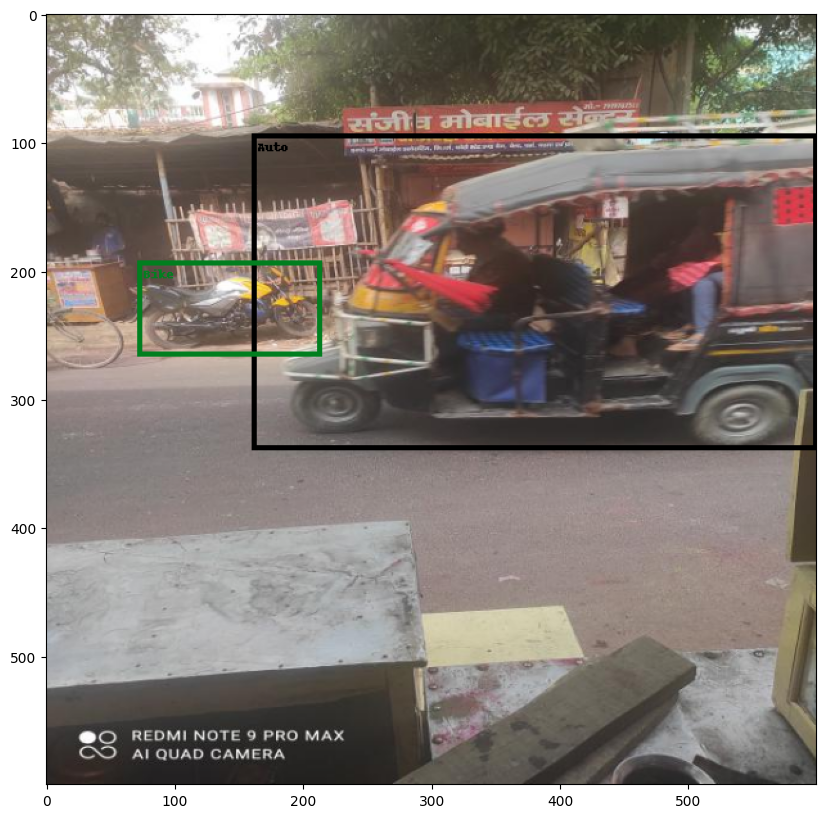

In [ ]:
fig = plt.figure(figsize=(14,10))
plt.imshow(draw_bounding_boxes(img_int,
                               pred['boxes'][pred['scores'] > 0.8],
                               [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],width = 4).permute(1,2,0))